In [92]:
! git clone https://github.com/DS3001/group9

fatal: destination path 'group9' already exists and is not an empty directory.


## Programming Lab #2
## Foundations of Machine Learning

The purpose of this project is to build predictive algorithms that predict the likelihood a person has a stroke. The data include:
  
  - `age`: Patient age, numeric
  - `avg_glucose_level`: Blood sugar levels, numeric
  - `bmi`: Body mass index, numeric
  - `ever_married`: Ever married, dummy/character (Yes, No)
  - `gender`: Male, Female, or Other, character
  - `heart_disease`: Has heart disease, dummy
  - `hypertension`: Has hypertension, dummy
  - `id`: Study identification number
  - `Residence_type`: Type of residence, dummy/character (Urban, Rural)
  - `smoking_status`: Former, never, or current smoker, categorical
  - `work_type`: Employment type (Never worked (Never_worked), homemaker ("children"), Public sector employment (Govt_job), Private sector employment (`Private`), Self-employed (`Self-employed`)
  - `stroke`: Suffered a stroke in the sample period
  
The data come in two files: `training_data.csv`, which you should use to build your models, and `testing_data.csv`, which you should use to test your models. The models must be trained on the training data and tested on the testing data, but providing both files allows you to experiment with your choices and iterate on model designs. If performance drops on the testing data, you know there's a problem.
  
You can use any of the tools presented in class: $k$ nearest neighbor, linear models, or decision trees. In principle, $k$ means clustering might also be helpful for looking for patterns in the data that the other methods might miss. Using canned versions of more advanced tools (boosting, bagging, random forests, neural networks, etc.) is deeply unsporting and thus not allowed. You can be creative about transforming variables, or combining decision trees with linear models or $k$NN. Try something interesting. Fail extravagantly. The goal is to work on an intellectually interesting question that is similar to the tasks that data scientists are called on to do every day.
  
We will compare the groups' models to see if there are common trends or significant differences, and also to declare **The Winners** on the basis of whichever team achieves the lowest $RMSE$ on the testing data. A simple linear model with some polynomials and dummy variables achieves an $R^2$ of .087 and a $RMSE$ of .206.

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.read_csv('./group9/project_2/data/training_data.csv')
df_test = pd.read_csv('./group9/project_2/data/testing_data.csv')

y_train = df_train['stroke']
X_train = df_train.drop('stroke',axis=1)
y_test = df_test['stroke']
X_test = df_test.drop('stroke',axis=1)

X_train['bmi'] = X_train['bmi'].fillna(X_train['bmi'].mean())
X_test['bmi'] = X_test['bmi'].fillna(X_test['bmi'].mean())


In [94]:
## Linear Model
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

X_train_numeric = X_train.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_train_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe
#
dummies = pd.concat([ pd.get_dummies(X_train['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_train['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_train = pd.concat([continuous,dummies],axis=1)

X_test_numeric = X_test.loc[:,['age','hypertension','heart_disease','bmi','avg_glucose_level'] ]
#
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
Z = expander.fit_transform(X_test_numeric) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
continuous = pd.DataFrame(data=Z, columns = names) # Create a new, expanded dataframe

dummies = pd.concat([ pd.get_dummies(X_test['work_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['Residence_type'],dtype='int',drop_first=True),
                      pd.get_dummies(X_test['smoking_status'],dtype='int',drop_first=True)],axis=1)
#
Z_test = pd.concat([continuous,dummies],axis=1)

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
print('R2: ', reg.score(Z_test, y_test)) # R squared measure
y_hat = reg.predict(Z_test)
N = len(y_test)
print('RMSE: ', (np.sum( (y_test - y_hat)**2)/N )**.5 )   # R squared measure


R2:  0.08717964343852191
RMSE:  0.20599583849612824


## Initial data imputations, transformations, and encoding

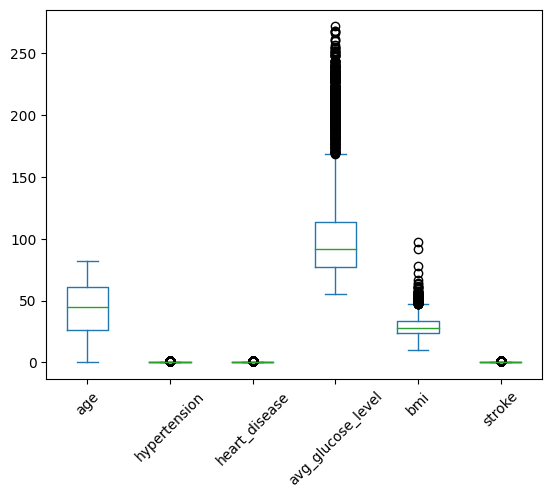

In [95]:
#### avg_glucose_level and bmi could use an arcsinh transformation
plt = df_train.drop('id', axis=1).drop('Unnamed: 0', axis=1).plot.box(rot=45)

In [96]:
df_train.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,2465,68685,Male,36.0,0,0,Yes,Govt_job,Urban,65.87,32.2,formerly smoked,0
1,4311,59058,Female,45.0,0,0,Yes,Govt_job,Rural,68.66,25.3,never smoked,0
2,2375,46068,Male,58.0,0,0,No,Self-employed,Rural,170.93,30.7,Unknown,0
3,5017,36837,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
4,753,30550,Female,78.0,0,0,No,Private,Urban,103.86,30.6,Unknown,0


In [97]:
# change ever_married to dummy
temp = df_train['ever_married'].replace('Yes', 1).replace('No', 0)
df_train['ever_married'] = temp


temp = df_test['ever_married'].replace('Yes', 1).replace('No', 0)
df_test['ever_married'] = temp


# investigate smoking_status
df_train['smoking_status'].unique() # should one hot encode these
ohe = pd.get_dummies(df_train['smoking_status'])

temp = pd.concat([df_train, ohe], axis=1)
temp = temp.drop('smoking_status', axis=1)
temp = temp.drop('Unknown', axis=1) # drop 'unknown' values from `smoking_status`
df_train_ohe = temp



df_test['smoking_status'].unique() # should one hot encode these
ohe = pd.get_dummies(df_test['smoking_status'])

temp = pd.concat([df_test, ohe], axis=1)
temp = temp.drop('smoking_status', axis=1)
temp = temp.drop('Unknown', axis=1) # drop 'unknown' values from `smoking_status`
df_test_ohe = temp



df_train_ohe.head()
df_test_ohe.head()


,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes
0,251,30468,Male,58.0,1,0,1,Private,Urban,87.96,39.2,0,0,1,0
1,252,16523,Female,8.0,0,0,0,Private,Urban,110.89,17.6,0,0,0,0
2,253,56543,Female,70.0,0,0,1,Private,Rural,69.04,35.9,0,1,0,0
3,255,32257,Female,47.0,0,0,1,Private,Urban,210.95,50.1,0,0,0,0
4,259,28674,Female,74.0,1,0,1,Self-employed,Urban,205.84,54.6,0,0,1,0


<Axes: >

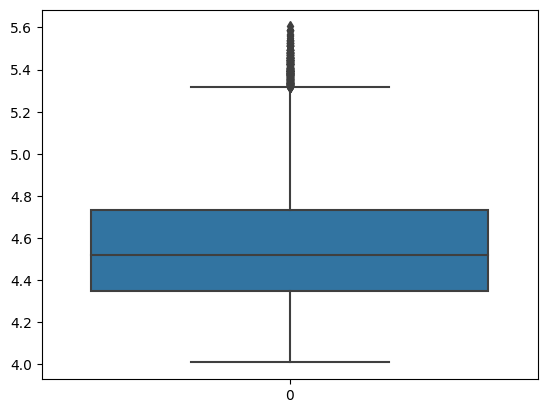

In [98]:
# arcsinh transformation on avg_glucose_level for better data distribution
df_train_ohe['avg_glucose_level'].describe()

#sns.kdeplot(df_train_ohe['avg_glucose_level'])

df_train_ohe['avg_glucose_level'] = np.log(df_train_ohe['avg_glucose_level'])
sns.boxplot(df_train_ohe['avg_glucose_level']) # still lots of outliers, lets 'windsorise' this variable

In [99]:
# all clean of nans
df_train_ohe['age'].unique()
df_train_ohe['hypertension'].unique()
df_train_ohe['heart_disease'].unique()
df_train_ohe['work_type'].unique()
df_train_ohe['Residence_type'].unique()
df_train_ohe['avg_glucose_level'].unique()

df_train_ohe['bmi'] = df_train['bmi'].fillna(df_train['bmi'].mean())
df_train_ohe['bmi'].unique()

df_test_ohe['bmi'] = df_test['bmi'].fillna(df_test['bmi'].mean())
df_test_ohe['bmi'].unique()

array([39.2     , 17.6     , 35.9     , 50.1     , 54.6     , 35.      ,
       22.      , 42.4     , 33.      , 24.6     , 27.3     , 27.      ,
       30.9     , 33.6     , 31.2     , 25.7     , 21.9     , 26.1     ,
       29.      , 23.6     , 39.5     , 64.8     , 35.1     , 21.      ,
       31.6     , 31.1     , 15.5     , 26.4     , 36.      , 40.3     ,
       23.8     , 23.7     , 37.9     , 31.      , 45.2     , 27.4     ,
       22.9     , 28.772579, 31.4     , 25.      , 28.9     , 39.7     ,
       41.2     , 34.8     , 31.7     , 35.8     , 28.3     , 41.6     ,
       19.      , 32.4     , 31.8     , 32.1     , 26.7     , 27.9     ,
       22.6     , 28.1     , 40.9     , 27.6     , 24.3     , 35.6     ,
       40.6     , 24.4     , 42.3     , 17.5     , 17.      , 47.8     ,
       27.1     , 23.1     , 30.2     , 36.4     , 22.1     , 40.5     ,
       23.      , 28.      , 22.8     , 55.7     , 26.9     , 18.3     ,
       36.2     , 21.4     , 20.4     , 34.2     , 

# DT with smoking_status encoded

In [100]:
# prepare variables for tree classification
### all categoricals w/ binary or one_hot_encoding

# FEMALE: 0, MALE: 1


temp = df_train['gender'].replace("Female", 0).replace("Male", 1).replace("Other",.5)
df_train_ohe['gender'] = temp

temp = df_test['gender'].replace("Female", 0).replace("Male", 1)
df_test_ohe['gender'] = temp


In [101]:
X_train = df_train_ohe[['hypertension', 'heart_disease', 'ever_married', 'never smoked', 'formerly smoked', 'smokes', 'gender', 'avg_glucose_level']]
y_train = df_train_ohe['stroke']

X_test = df_test_ohe[['hypertension', 'heart_disease', 'ever_married', 'never smoked', 'formerly smoked', 'smokes', 'gender', 'avg_glucose_level']]
y_test = df_test_ohe['stroke']

In [102]:
## Decision Tree
## Decision Tree
from sklearn import tree
import matplotlib.pyplot as plt


model = tree.DecisionTreeClassifier() # Fit the classifier
cart = model.fit(X_train, y_train)
plt.figure(figsize=(50,20)) # Adjust the size as needed
#tree.plot_tree(cart,
#               filled=True,
 #              feature_names=X_train.columns,
  #             class_names=True,
   #            rounded=True,
    #           fontsize=12)
plt.show()
print(model.feature_importances_)



<Figure size 5000x2000 with 0 Axes>

[0.01853562 0.01937806 0.02416053 0.0223807  0.0180496  0.02890248
 0.0356425  0.83295052]


<Axes: >

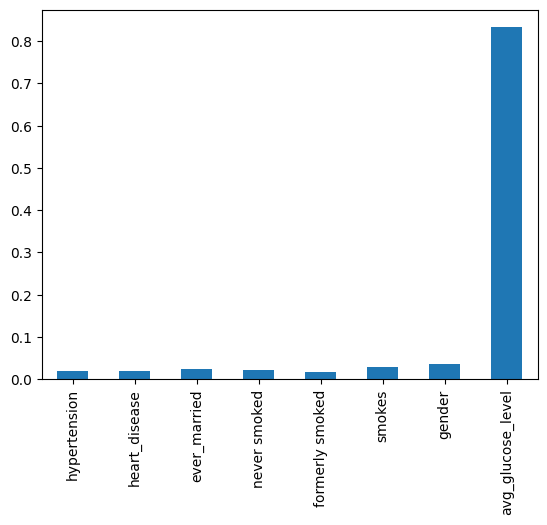

In [103]:
# Variable importance plot:
dt_importances = pd.Series(cart.feature_importances_, index=X_train.columns )
dt_importances.plot.bar()
# visualization of feature importances. good to move forward

0.2360476118780145
[0 1]


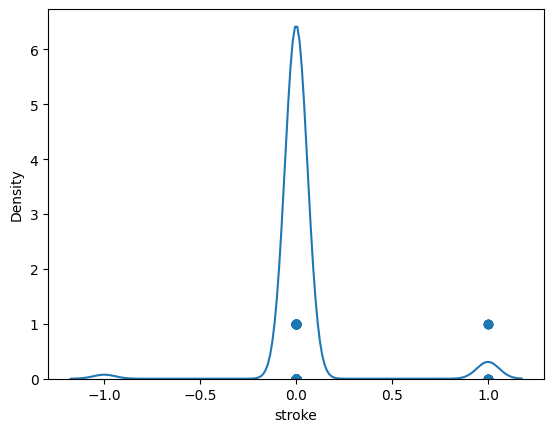

In [104]:

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)

## True versus predicted plot:
plt.scatter(y_hat_cart,y_test)



SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/len(y_test))*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/len(y_test))**(1/2)

TSS = np.sum( (y_test - y_train.mean())**2 ) # found in model_evaluation doc

R2_cart = 1 - SSE_cart/TSS

print(RMSE_cart)
print(np.unique(y_hat_cart))

# Results

Decision Tree.

Our first more advanced model is the decision tree. The decision tree works by creating strategic splits to determine categorical outcomes. This model makes logical sense for a model such as health outcomes. It is not unlikely that many people have experienced a situation in which one’s doctor asks a series of health questions to obtain a predictive diagnosis. This model works in a very similar way. In doing so the model is able to trade expertise and experience for incredible amounts of raw data in order to make predictions. Here the model predicts...


The model uses several key dummy variables as well as a one continuous variable, average glucose level, to make categorical predictions on stroke outcome. The first major split is on glucose level <= 5.088 creating a 3563/524 split. The right branch, suggesting high glucose levels, has a 73/451 = .161 Strok:NoStroke ratio while the lower glucose level left branch has a 126/3437 = .036 Stroke:NoStroke ratio. It therefore makes sense that the model would find this to be a strong first split since the groups show such varying outcome ratios. The model finds its first terminal node following the right branch. Subsequent decisions show that no heart disease and low glucose (within the set of avg_glucose_level>=5.088) find the quickest terminal node. It appears the model relies heavily on average glucose. With each split further refinement is found through precision in exact glucose level. This would make sense since almost all of the other variables are binary. As such glucose level is the only place where the model is able to make anything other than binary splits.

Additionally binary variables describing marriage occur frequently and appear for the first time within the third layer of the tree. It is interesting to consider why marriage status has an effect on stroke outcome or if there may be a form of omitted variable bias applying extra predictive weight to marital status. The leftmost occurrence of ever_married splits the data 1287/1891, with the left branch (no marriage) showing a .0117 Stroke:NoStroke ratio and right branch (marriage) showing a .0379 Stroke:NoStroke ratio. The rightmost appearance shows a 19/168 split with a left side .267 Stroke:NoStroke ratio and right side .05 Stroke:Nostroke ratio. Thus it appears that the impact of marriage increases the chance of stroke in the generally healthier left branch while the generally less healthy right branch unmarried people are more likely to have a stroke. This could occur for many reasons but will likely occur due to some omitted variable which biases the impact of marriage. While marriage can single out many attributes from the inherent partnership relationship, however it seems less likely that marriage so strongly predicts stroke. Other variables make far more sense such as ever smoked, which has direct health outcomes.

When considering the predictive significance the RMSE is found to be .236. When compared to the base linear model with an RMSE of .206 this model is in fact worse. This could be due to a variety of decisions such as only including dummy variables, leading the model to rely very heavily on the one continuous variable, glucose level. In our subsequent models we hope to find more nuanced models that will help to have better predictive statistics.


<font color = "green">
My first instinct was to experiment implementing a decision tree regressor model with one_hot_encoded `smoking_status` variable and other relevant binary and numeric variables. Next thing I would like to try is almost "categorizing" the bmi value by one_hot_encoding the values within each range of the bmi spectrum. For example, I will first go through and recode each value as underweight, normal weight, over weight, or obese. This variable will then be one_hot_encoded and possibly featured with polynomials with other key variables like glucose level. </font>

# Feature engineering for better results

In [105]:
# create bmi grouping variable
underweight_threshold = 18.5
normal_threshold = 24.9
overweight_threshold = 29.9

# Create a new column 'BMI Classification' based on BMI values
df_train_ohe['bmi_group'] = pd.cut(df_train_ohe['bmi'],
                                   bins=[0, underweight_threshold, normal_threshold, overweight_threshold, float('inf')],
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
                                   right=False)

df_test_ohe['bmi_group'] = pd.cut(df_test_ohe['bmi'],
                                   bins=[0, underweight_threshold, normal_threshold, overweight_threshold, float('inf')],
                                   labels=['Underweight', 'Normal', 'Overweight', 'Obese'],
                                   right=False)

pd.crosstab(df_train_ohe['bmi_group'], df_train_ohe['stroke'])

stroke,0,1
bmi_group,,
Underweight,270,1
Normal,924,31
Overweight,1216,85
Obese,1478,82


Looking at the crosstab between stroke and BMI groups, it is clear that weight is an important explanatory factor for stroke prediction. 167/199 or 83.9% of individuals who had a stroke were at least classified as overweight based on their BMI.


In [106]:
pd.crosstab(df_train_ohe['gender'], df_train_ohe['stroke'])

stroke,0,1
gender,,
0.0,2286,112
0.5,1,0
1.0,1601,87


In [107]:
# Need to one-hot-encode new 'bmi_group' variable
temp = pd.get_dummies(df_train_ohe['bmi_group'])
temp = pd.concat([df_train_ohe, temp], axis=1)
df_train_ohe = temp

temp = pd.get_dummies(df_test_ohe['bmi_group'])
temp = pd.concat([df_test_ohe, temp], axis=1)
df_test_ohe = temp

df_test_ohe.head()

,Unnamed: 0,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,formerly smoked,never smoked,smokes,bmi_group,Underweight,Normal,Overweight,Obese
0,251,30468,1,58.0,1,0,1,Private,Urban,87.96,39.2,0,0,1,0,Obese,0,0,0,1
1,252,16523,0,8.0,0,0,0,Private,Urban,110.89,17.6,0,0,0,0,Underweight,1,0,0,0
2,253,56543,0,70.0,0,0,1,Private,Rural,69.04,35.9,0,1,0,0,Obese,0,0,0,1
3,255,32257,0,47.0,0,0,1,Private,Urban,210.95,50.1,0,0,0,0,Obese,0,0,0,1
4,259,28674,0,74.0,1,0,1,Self-employed,Urban,205.84,54.6,0,0,1,0,Obese,0,0,0,1


In [108]:
pd.crosstab(df_train_ohe['gender'], df_train_ohe['stroke'])
print("Percent of females with stroke: ", (112/2286)*100)
print("Percent of males with stroke: ", (87/1601)*100)

Percent of females with stroke:  4.899387576552931
Percent of males with stroke:  5.434103685196752


<ipython-input-109-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-109-2aa2295d2d7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker
<ipython-input-109-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-109-2aa2295d2d7a>:14: SettingWithC

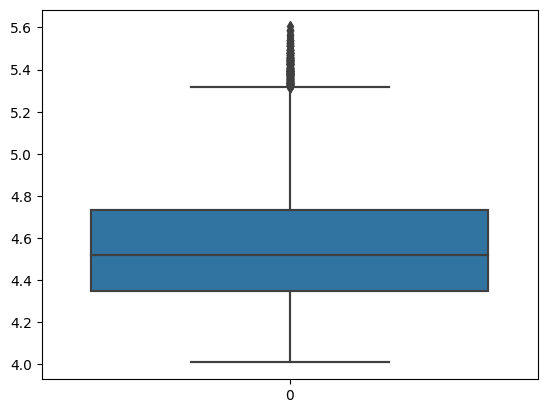

In [109]:
sns.boxplot(df_train_ohe['avg_glucose_level']) # still lots of outliers, lets 'windsorise' this variable

## Function to compute whiskers:                      # gotten from model_evaluation.ipynb
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

sns.boxplot( windsorize(df_train_ohe['avg_glucose_level'])) # looks better
df_train_ohe['avg_glucose_level'] = windsorize(df_train_ohe['avg_glucose_level'])

Axes(0.125,0.11;0.775x0.77)
Axes(0.125,0.11;0.775x0.77)


<ipython-input-109-2aa2295d2d7a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-109-2aa2295d2d7a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


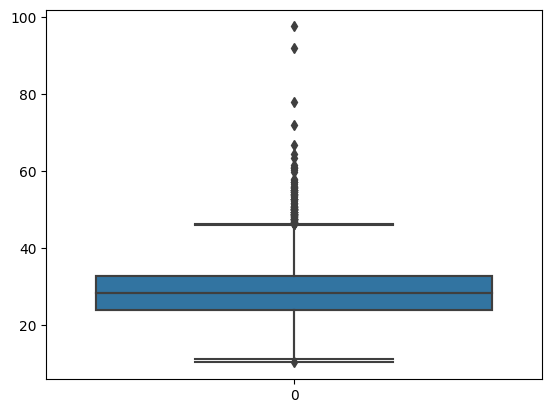

In [110]:
print(sns.boxplot(df_train_ohe['bmi']))
df_train_ohe['bmi'] = windsorize(df_train_ohe['bmi'])
print(sns.boxplot(df_train_ohe['bmi']))

Axes(0.125,0.11;0.775x0.77)


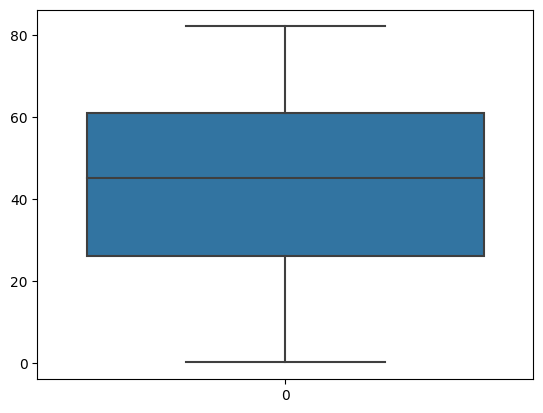

In [111]:
print(sns.boxplot(df_train_ohe['age']))

# DT with winsorized `avg_glucose_level` and `bmi`

After trial and error model exploration, it is apparent that grouping BMI decreased model accuracy. Variables were removed if they had a low feature importance after observing the bar chart of feature importances. The

In [112]:
#X_train = df_train_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'Normal', 'Underweight', 'Overweight', 'Obese']]
#y_train = df_train_ohe['stroke']

#X_test = df_test_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'Normal', 'Underweight', 'Overweight', 'Obese']]
#y_test = df_test_ohe['stroke']

In [113]:
# only include vars with high feature importances as pictured above "# Variable importance plot:""
X_train = df_train_ohe[['hypertension', 'heart_disease', 'smokes','gender',  'avg_glucose_level', 'bmi', 'age']]
y_train = df_train_ohe['stroke']

X_test = df_test_ohe[['hypertension', 'heart_disease', 'smokes', 'gender', 'avg_glucose_level', 'bmi', 'age']]
y_test = df_test_ohe['stroke']


[0.01761448 0.02378741 0.         0.04804499 0.25465444 0.08477532
 0.57112337]
0.2254570680652238


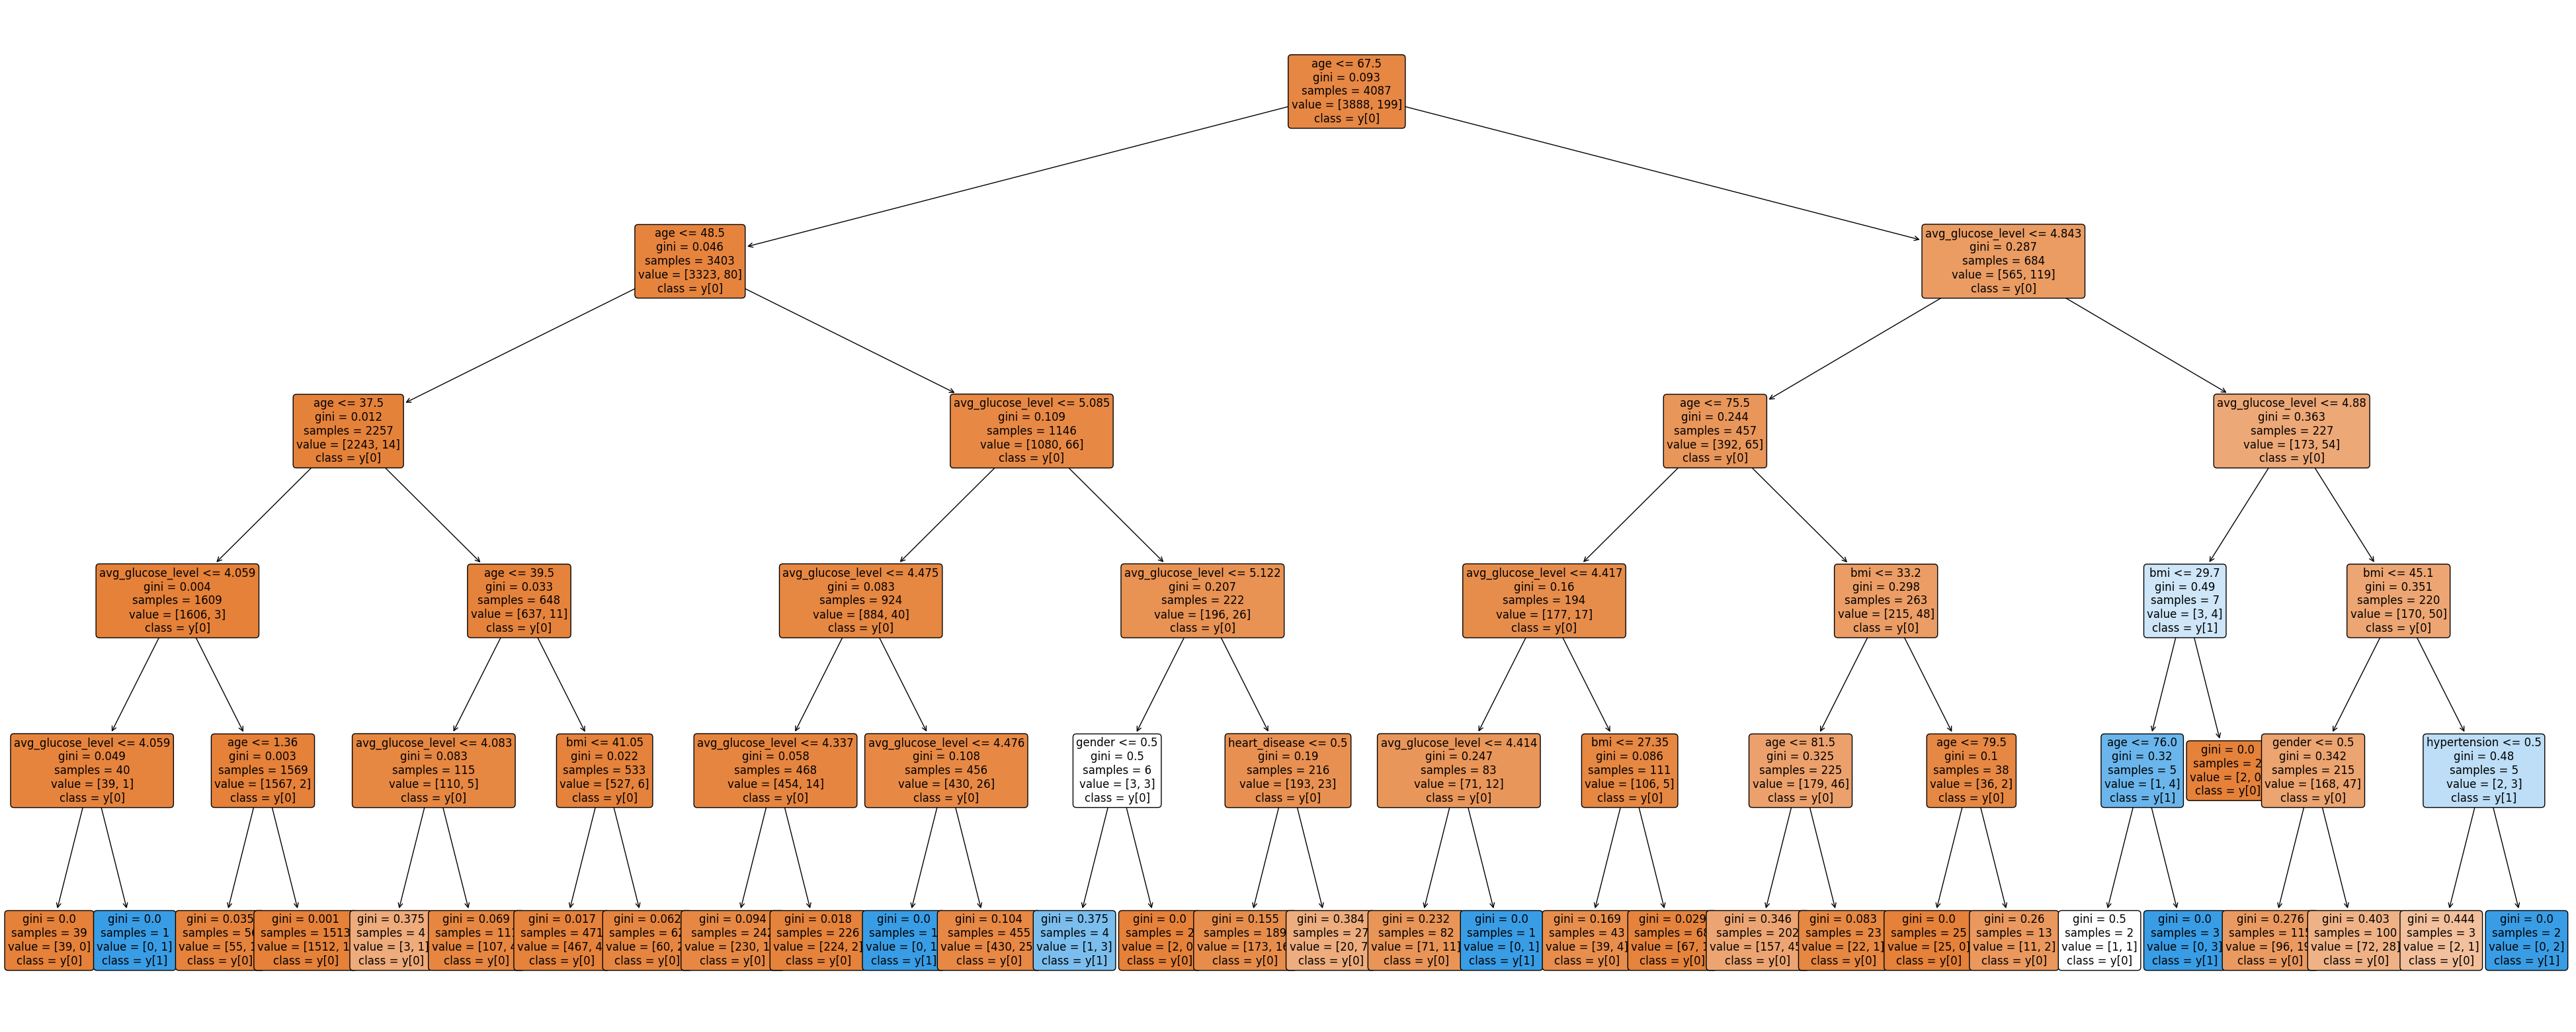

In [114]:
## Decision Tree
from sklearn import tree
## Decision Tree
from sklearn import tree
import matplotlib.pyplot as plt

model = tree.DecisionTreeClassifier(max_depth=5) # Fit the classifier
cart = model.fit(X_train, y_train)
plt.figure(figsize=(50,20)) # Adjust the size as needed
tree.plot_tree(cart,
               filled=True,
               feature_names=X_train.columns,
               class_names=True,
               rounded=True,
               fontsize=12)

print(model.feature_importances_)
## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/len(y_test))*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/len(y_test))**(1/2)

TSS = np.sum( (y_test - y_train.mean())**2 ) # found in model_evaluation doc

R2_cart = 1 - SSE_cart/TSS

print(RMSE_cart)

After looking deeper into BMI and understanding its importance to the model, we ran a second decision tree, adding variables we thought would be important, including “age,” “gender,” and “bmi” and removing variables such as “ever_married” that we deemed insignificant for the model. The results for the new decision tree with a winsorized avg_glucose_level and bmi are promising and improve upon the initial model. The RSME improved to a 0.221, which is better than the original decision tree and suggests improved performance and accuracy in predictions. However, the RSME is still slightly larger than the original linear mode, so more feature engineering might be necessary to transform data and make relationships in the data easier to capture.  

The new model adds two numeric, continuous variables to the original decision tree that are both used extensively to make stroke predictions. Compared to the first tree, the initial split in this classification is age at 67.5. At an age greater than 67, 119/199 or 59.8% of all strokes occurred. To continue, 119/684 or 17.4% of individuals over the age of 67 had a stroke. On the other hand, for those 67 and younger, 80/3403 or 2.35% of individuals had a stroke. As the root node of the tree, according to the algorithm's criteria, age is the best variable to separate the data with respect to the response variable, largely dictating the rest of the tree’s structure. This makes sense as an increase in age is correlated naturally with the narrowing of arteries. As clogged arteries are the primary cause of strokes, age is a very significant predictor. Another important node regarding “age” can be found going down the left side of the tree. For individuals with no other classification except below the age of 37.5, only 3/1609 or .1864% of individuals suffered a stroke. This figure alone displays how drastic changes in age play in stroke occurrences.

As the majority of strokes are located further down the right branches of the tree, the next significant variable in explaining variation in strokes among individuals is “avg_glucose_level.” At a glucose level of 4.843 mmol/L, the sample splits again, where the stroke to sample percentage in higher blood sugar levels is prevalent. For those that are over 67, higher blood sugar individuals had a 54/227 or 23.8% chance of having a stroke compared to the 65/457 or 14.223% chance in lower blood sugar individuals. Blood sugar levels are also deemed strong predictors in younger individuals. From the 3 individuals under 37.5 who had a stroke, all 3 of them also had a blood sugar level over 4.059 mmol/L.Once again, along with age, quanitiative health metrics directly related to the bloodstream and arteries are strong predictors.


<Axes: >

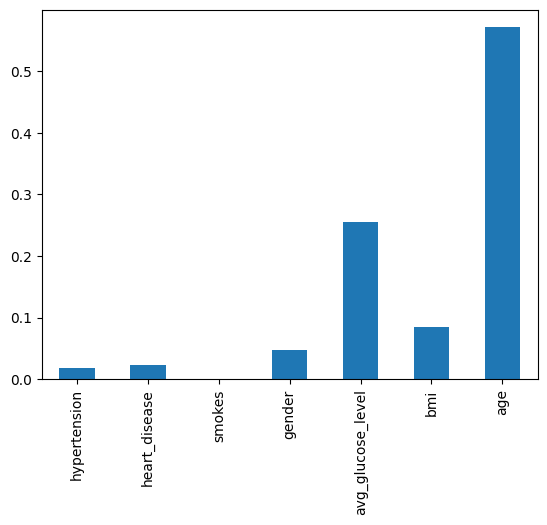

In [115]:
#Variable importance plot:
dt_importances = pd.Series(cart.feature_importances_, index=X_train.columns )
dt_importances.plot.bar()

<Axes: xlabel='stroke', ylabel='Density'>

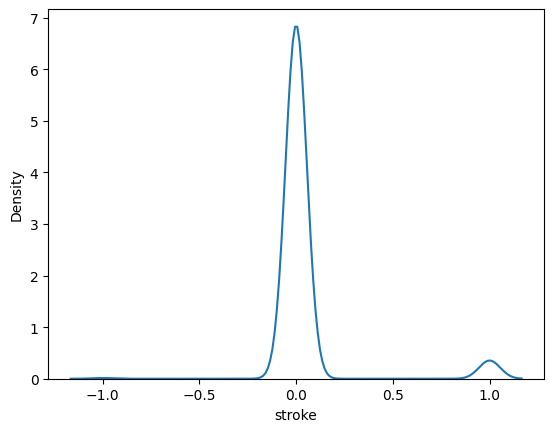

In [116]:
## Residual plot:
sns.kdeplot(residuals_cart)

Above, the density at 0 represents the correctly predicted observations, while the density at -1 represents when participants did not experience a stroke when the model predicted they would, and the density at 1 represents when participants did experience a stroke and the decision tree predicted no stroke. Even though the RMSE of the model increases, it gives some insight into what is happening, what is going wrong. -1 would be a False Positive, so the presense of no FPs and only False Negatives suggest it is not fit well enough.

# Trying Random Forests

In [117]:
from sklearn.ensemble import RandomForestClassifier as rfc

# Fit model:
model = rfc() # Build a random forest model
rf = model.fit(X_train,y_train) # Fit the rf model

# Make predictions:
y_hat_rf = rf.predict(X_test) # Model predictions



0.9413489736070382

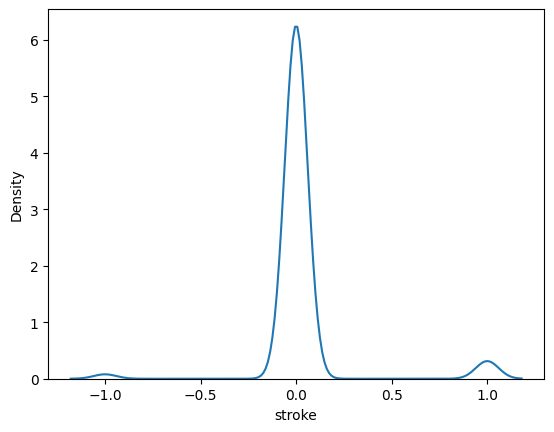

In [118]:
# Residual plot:
residual = y_test - y_hat_rf
sns.kdeplot(x=residual)
# Rsq measure
rf.score(X_test,y_test)

Disregard the rf.score() printed above the density plot.

This Random Forest model seems to provide a little more accurate of predictions without making classifications. Densities to the left of 0 are cases where Stroke did not occur when the model predicted small likelihood of stroke. This density left of 0 is fairly high between -0.25 and 0, suggesting the model often predicted slight possibilities of stroke when stroke did not occur. The density peak near 1 is from observations where Stroke did occur and the model predicted low chances of occurence. This seems to be a repeating trend in the models, suggesting there is another important feature that needs to be taken into account. Typically, we would call these OUTLIERS, but let's try to predict them.

This RF does not classify, but the kernel density plot of the residuals shows closer, more accurate modeling of the observed. Though this RF helps provides valuable insight into the nature of how this data is being modeled through different ML procedures. Let's try to work back to classification to get definitive 1s and 0s.

This is supposed to be fairly "fun," so please do not turn it into a combinatorial nightmare of comparing thousands of model specifications. Settle on a strategy you think is promising, crank it out, and write up the results. Your time and energy are valuable, so learn to recognize when the marginal cost of another twenty minutes on a project exceeds the benefit in terms of improving the results and your grade.
  
# Paper format

The format of the paper should be:

  - Summary: A one paragraph description of the question, methods, and results (about 350 words).
  - Data: One to two pages discussing the data and key variables, and any challenges in reading, cleaning, and preparing them for analysis.
  - Results: Two to five pages providing visualizations, statistics, a discussion of your methodology, and a presentation of your main findings.
  - Conclusion: One to two pages summarizing the project, defending it from criticism, and suggesting additional work that was outside the scope of the project.
  - Appendix: If you have a significant number of additional plots or table that you feel are essential to the project, you can put any amount of extra content at the end and reference it from the body of the paper.

## Submission

Half of each student's grade is based on their commits to the repo. Each student is expected to do something specific that contributes to the overall project outcome. Since commits are recorded explicitly by Git/GitHub, this is observable. A student can contribute by cleaning data, creating visualizations,performing analytic analyses,  or writing about results, but everyone has to do something substantial. A student's work doesn't need to make it into the final report to be valuable and substantial, and fulfill the requirement to make a contribution to the project.

The other half of each student's grade is based on the written report. Groups will work together on combining results and writing up findings in a Jupyter noteb,ok, using code chunks to execute Python commands and markdown chunks to structure the paper and provide exposition. The notebook should run on Colab or Rivana from beginning to end without any errors.

mbers submit.

## Criteria

The project is graded based on four criteria:

  - Project Concept: What is the strategy for building and testing the group's models? How did the group decide how to use the tools presented so far in class? How did the group compare the performance of the options considered, and settle on a final choice for submission?
  - Wrangling, EDA, and Visualization: How are are missing values handled? For variables with large numbers of missing values, to what extent do the data and documentation provide an explanation for the missing data? If multiple data sources are used, how are the data merged? For the main variables in the analysis, are the relevant data summarized and visualized through a histogram or kernel density plot where appropriate? Are basic quantitative features of the data addressed and explained? How are outliers characterized and addressed?
  - Analysis: What are the groups' main findings? Do the tables, plots, and statistics support the conclusions? Is the research strategy carried out correctly? If the research strategy succeeds, are the results interpreted correctly and appropriately? If the research strategy fails, is a useful discussion of the flaws of the data collection process or the research strategy discussed?
  - Replication/Documentation: Is the code appropriately commented? Can the main results be replicated from the code and original data files? Are significant choices noted and explained?

Each of the four criteria are equally weighted (25 points out of 100).